# Theory Analysis at given quantile across latitudes
This notebook applies the adiabatic theory for convectively set change in temperature to a range of latitudes.

It is adapted from the [theory breakdown.ipynb](https://github.com/jduffield65/Isca/blob/main/jobs/tau_sweep/land/meridional_band/publish_figures/theory_breakdown.ipynb) notebook used for Isca simulations.

In [1]:
import copy
import sys
import os

import warnings


# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory, get_approx_terms, get_sensitivity_factors, get_cape_approx
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import integrate
import matplotlib.ticker as mticker
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

#### Load in Data
Quantile data is obtained from CESM datasets and output into npz files. Here I am just interested in the npz files. For quantile data, the shape of array is `[2, n_lat, n_quant]` where the first index is `0` for land and `1` for ocean coordinates (quantiles are found separately at each latitude for land and ocean).

In [40]:
dir_out = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/tropics_summer'
exp_id = ['pre_industrial', 'co2_4x']
n_exp = len(exp_id)
exp_names = []
for i in range(n_exp):
    if exp_id[i] == 'pre_industrial':
        exp_names.append('e.e20.E1850TEST.f09_g17.daily_output')
    else:
        exp_names.append(f'e.e20.E1850TEST.f09_g17.{exp_id[i]}_daily_output')
# exp_names = ['e.e20.E1850TEST.f09_g17.daily_output', 'e.e20.E1850TEST.f09_g17.co2_2x_daily_output']
# exp_names = ['isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=1', 'isca/tau_sweep.land.meridional_band.depth=1.bucket_evap.k=2']

# if not np.all(ds_base[0]['quant']==ds_base[1]['quant']):
#     raise ValueError('Quantiles change between datasets')
#
# if not np.all(ds_base[0]['lat']==ds_base[1]['lat']):
#     raise ValueError('Latitudes change between datasets')
#
# if not np.all(ds_base[0]['surface']==ds_base[1]['surface']):
#     raise ValueError('Surface change between datasets')
ds = []
with tqdm(total=n_exp*2+n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = []
        for j, surface in enumerate(['ocean', 'land']):
            ds_use.append(xr.open_dataset(os.path.join(dir_out, f'{exp_id[i]}/{surface}/output.nd2')))

            # Drop variables not used
            vars_to_drop = [var for var in ds_use[j].data_vars if 'std' in var and var != 'T_std']         # remove all error variables except temp
            vars_to_drop += [var for var in ds_use[j].data_vars if 'mse' in var and var != 'mse_lapse']
            vars_to_drop += ['Z3', 'SOILLIQ', 'pressure_ft', 'use_in_calc']    # drop use_in_calc as so large

            ds_use[j] = ds_use[j].drop_vars(vars_to_drop).load()
            pbar.update(1)
        ds.append(xr.concat(ds_use, dim='surface'))
        # landmask and gw are the same for both datasets
        ds[i]['landmask'] = ds[i]['landmask'].isel(surface=0)
        ds[i]['gw'] = ds[i]['gw'].isel(surface=0)
        # Find all latitudes with at least one longitude of given surface
        ds[i]['is_surf'] = (ds[i].landmask.sum(dim='lon')!=0) * (ds[i].surface=='land') + (
                np.invert(ds[i].landmask).sum(dim='lon')!=0) * (ds[i].surface=='ocean')
        pbar.update(1)

  0%|          | 0/6 [00:00<?, ?it/s]

In [41]:
# Get pressure info
ind_surf = 0
ind_ft = 1
pressure_surf = float(ds[0].lev[ind_surf]) * 100
pressure_ft = float(ds[0].lev[ind_ft]) * 100

In [42]:
# Compute approx CAPE
if 'rh' not in ds:
    warnings.warn('RH not in ds, so calculating from sphum')
    ds['rh'] = ds['sphum']/sphum_sat(ds['temp'], pressure_surf)
n_surf = ds[0].surface.size
n_quant = ds[0].quant.size
n_lat = ds[0].lat.size
cape_approx = np.zeros((n_exp, n_surf, n_quant, n_lat))
for i in range(n_exp):
    for j in range(n_surf):
        for k in range(n_quant):
            cape_approx[i, j, k] = get_cape_approx(ds[i].T.isel(surface=j, quant=k, lev=ind_surf).to_numpy(), ds[i].rh.isel(surface=j, quant=k).to_numpy(),
                                                   pressure_surf, pressure_ft, ds[i].T.isel(surface=j, quant=k, lev=ind_ft).to_numpy(),
                                                   ds[i].mse_lapse.isel(surface=j, quant=k).to_numpy())[0]
    ds[i]['cape_approx'] = ds[i].mse_lapse*0 + cape_approx[i]      # use mse_lapse as a base and add to it, as have same dimensions

In [43]:
# Set reference dataset at each latitude to be conditioned on quant=50
# Note that should save mean and median values as well
ds_ref = [ds[i].isel(quant=50, lev=0)[['T', 'rh']] for i in range(n_exp)]

## Theory
Below I plot how well various versions of the theory do.

In [44]:
def get_exp_quant_array(ds_list, var, surf_ind, lat_ind, lev_ind=None):
    # Returns an n_exp x n_quant array of given variable where ds_list contains n_exp datasets
    var_ind = {'surface': surf_ind, 'lat': lat_ind, 'lev': lev_ind}
    dims = ds_list[0][var].dims & var_ind.keys()        # only consider dimensions in both variable and var_ind
    return np.asarray([ds_list[i][var].isel({key: var_ind[key] for key in dims}).to_numpy() for i in range(len(ds_list))])

In [45]:
sf_simulated = (ds[1].T - ds[0].T).isel(lev=ind_surf) / (ds_ref[1].T - ds_ref[0].T)
sf_simulated_error = np.sqrt((ds[0].T_std/(ds[1].T - ds[0].T)).isel(lev=ind_surf)**2 +
                             (ds[1].T_std/(ds[1].T - ds[0].T)).isel(lev=ind_surf)**2)
# Make simulated scale factor same shape as theory
sf_simulated = sf_simulated.transpose("surface", "lat", "quant")
sf_simulated_error = sf_simulated_error.transpose("surface", "lat", "quant")

sf_theory = {key: np.zeros((n_surf, n_lat, n_quant)) for key in ['linear', 'non_linear']}
# gamma_ft = np.zeros((n_surf, n_quant))
sf_theory_breakdown = {key: np.zeros((n_surf, n_lat, n_quant)) for key in
                       ['temp_ft_change', 'r_change', 'temp_anom', 'r_anom', 'cape_change']}

sf_theory_approx = {key: np.zeros((n_surf, n_lat, n_quant)) for key in
                                  ['temp_ft_anom_change', 'temp_s_anom_change', 'r_change', 'temp_s_anom_r_change', 'anom_temp_s_r',
                                   'anom', 'ref_change', 'z_anom_change', 'nl', 'cape']}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for i in range(n_surf):
        for j in range(n_lat):
            for key in sf_theory:
                sf_theory[key][i, j], info_coef, _, info_cont = \
                    get_scale_factor_theory(get_exp_quant_array(ds_ref, 'T', i, j, ind_surf), get_exp_quant_array(ds, 'T', i, j, ind_surf),
                                            get_exp_quant_array(ds_ref, 'rh', i, j), get_exp_quant_array(ds, 'rh', i, j),
                                            get_exp_quant_array(ds, 'T', i, j, ind_ft), get_exp_quant_array(ds, 'mse_lapse', i, j),
                                            pressure_surf, pressure_ft, include_non_linear='non_linear' in key, cape_form=True)
                if key == 'linear':
                    # Only record breakdown for linear case as easier to interpret
                    for key2 in sf_theory_breakdown:
                        sf_theory_breakdown[key2][i, j] = info_cont[key2]
            var = get_approx_terms(get_exp_quant_array(ds_ref, 'T', i, j, ind_surf), get_exp_quant_array(ds, 'T', i, j, ind_surf),
                                   get_exp_quant_array(ds_ref, 'rh', i, j), get_exp_quant_array(ds, 'rh', i, j),
                                   get_exp_quant_array(ds, 'T', i, j, ind_ft), get_exp_quant_array(ds, 'mse_lapse', i, j),
                                   pressure_surf, pressure_ft, cape_form=True)[0]
            for key2 in sf_theory_approx:
                sf_theory_approx[key2][i, j] = var[key2]

        # Set regions with none of that surface to nan
        if str(ds[0].surface[i].values) == 'land':
            nan_ind = np.where(ds[0].landmask.sum(dim='lon')==0)[0]
        else:
            nan_ind = np.where(np.invert(ds[0].landmask).sum(dim='lon')==0)[0]
        sf_simulated.isel(surface=i)[:, nan_ind] = np.nan
        for key in sf_theory:
            sf_theory[key][i, :, nan_ind] = np.nan
        for key2 in sf_theory_breakdown:
            sf_theory_breakdown[key2][i, :, nan_ind] = np.nan
        for key2 in sf_theory_approx:
            sf_theory_approx[key2][i, :, nan_ind] = np.nan


In [46]:
lat_weights = ds[0].gw/ds[0].gw.sum()
quant_median_ind = int(np.where(ds[0].quant==50)[0])
def plot_sf(var, ax_lat=0, lat_weights=lat_weights, ax_quant=1, norm_by_median=False, median_ind=quant_median_ind):
    if norm_by_median:
        return np.average(var - np.take(var, indices=[median_ind], axis=ax_quant) + 1, axis=ax_lat, weights=lat_weights)
    else:
        return np.average(var, axis=ax_lat, weights=lat_weights)

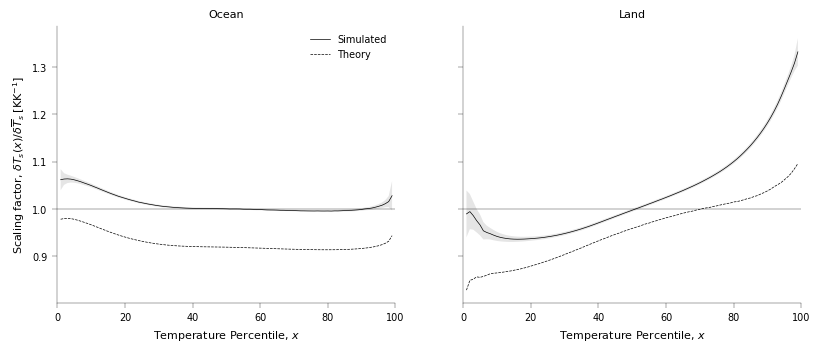

In [47]:
norm_median = False

save_sf_theory_fig = False
fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    ax[i].plot(ds[0].quant, plot_sf(sf_simulated[i].to_numpy(), norm_by_median=norm_median), color='k', label='Simulated')
    ax[i].plot(ds[0].quant, plot_sf(sf_theory['linear'][i], norm_by_median=norm_median), color='k', linestyle='--', label='Theory')
    ax[i].fill_between(ds[0].quant, plot_sf(sf_simulated[i].to_numpy() - sf_simulated_error[i].to_numpy(), norm_by_median=norm_median),
                       plot_sf(sf_simulated[i].to_numpy() + sf_simulated_error[i].to_numpy(), norm_by_median=norm_median), fc='k', alpha=0.1)
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Temperature Percentile, $x$')
    ax[i].set_title(str(ds[0].surface[i].values).capitalize())
ax[0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
ax[0].legend()
ax[0].set_xlim(0, 100)
# fig.suptitle(f'Temperature Percentile, $x$', fontsize=9)
plt.show()
if save_fig or save_sf_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_theory.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Breakdown into 4 change contributions
The theory can be split into 4 change ($\delta$) terms:

* $\delta \overline{T_s}$
* $\delta \overline{r_s}$
* $\delta \overline{\epsilon_s}$
* $\delta \Delta \chi(x)$ terms for $\chi = r, T_{FT}, \epsilon$

Here I plot the contribution of each of these (assuming the linear theory).

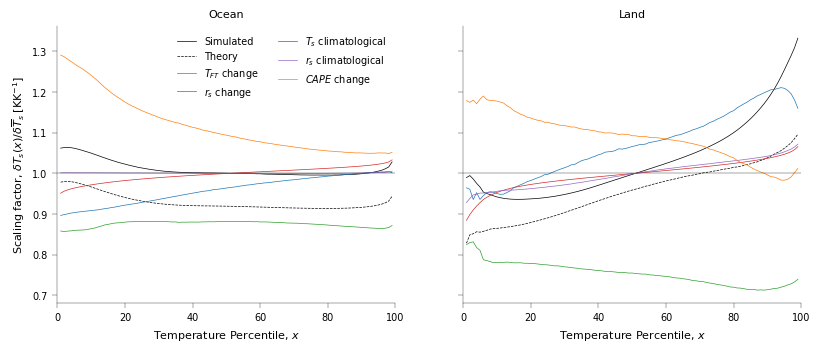

In [53]:
colors_cont = {'temp_ft_change': default_colors[2],
               'temp_anom': default_colors[3], 'r_anom': default_colors[4],
               'r_change': default_colors[0],
               'cape_change': default_colors[1]}
labels_cont = {'temp_ft_change': '$T_{FT}$ change', 'r_change': '$r_s$ change', 'cape_change': '$CAPE$ change',
               'temp_anom': '$T_s$ climatological', 'r_anom': '$r_s$ climatological'}

norm_median = False
save_breakdown_change_fig = False
fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    # ax[i].plot(lat, sf_simulated[i, q_plot_ind], color='k', label='Simulated')
    ax[i].plot(ds[0].quant, plot_sf(sf_simulated[i].to_numpy(), norm_by_median=norm_median), color='k', label='Simulated')
    ax[i].plot(ds[0].quant, plot_sf(sf_theory['linear'][i], norm_by_median=norm_median), color='k', linestyle='--', label='Theory')
    for key1 in sf_theory_breakdown:
        ax[i].plot(ds[0].quant, plot_sf(sf_theory_breakdown[key1][i], norm_by_median=norm_median) +
                   (1 if (not norm_median) and ('ft' not in key1) else 0),
                   color=colors_cont[key1], label=labels_cont[key1])
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Temperature Percentile, $x$')
    ax[i].set_title(str(ds[0].surface.values[i]).capitalize())
ax[0].legend(ncol=2)
ax[0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
ax[0].set_xlim(0, 100)
plt.show()
if save_fig or save_breakdown_change_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sf_breakdown_change.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

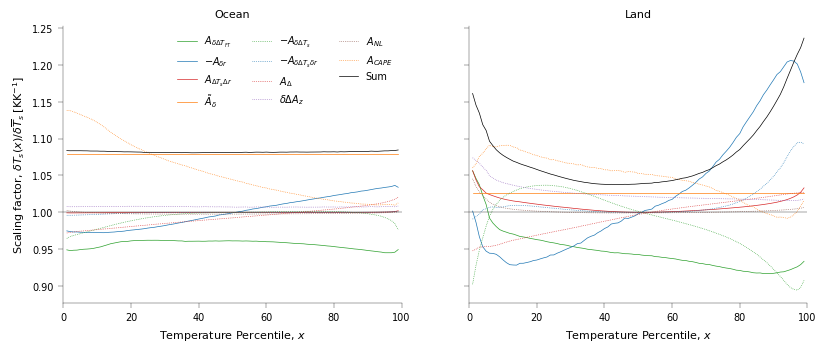

In [49]:
colors_approx = {'temp_ft_anom_change': default_colors[2], 'r_change': default_colors[0], 'anom_temp_s_r': default_colors[3],
                 'ref_change': default_colors[1],
                 'temp_s_anom_change': default_colors[2], 'temp_s_anom_r_change': default_colors[0], 'anom': default_colors[3],
                 'z_anom_change': default_colors[4], 'nl': default_colors[5], 'cape': default_colors[1]}
linestyles_approx = {'temp_ft_anom_change': None, 'r_change': None, 'anom_temp_s_r': None, 'ref_change': None,
                     'temp_s_anom_change': ':', 'temp_s_anom_r_change': ':', 'z_anom_change': ':', 'anom': ':', 'nl': ':', 'cape': ':'}
labels_approx = {'temp_ft_anom_change': '$A_{\delta \Delta T_{FT}}$', 'r_change': '$-A_{\delta r}$', 'anom_temp_s_r': '$A_{\Delta T_s \Delta r}$',
                 'ref_change': '$\\tilde{A}_{\delta}$', 'temp_s_anom_change': '$-A_{\delta \Delta T_s}$',
                 'temp_s_anom_r_change': '$-A_{\delta \Delta T_s \delta r}$', 'z_anom_change': '$\delta \Delta A_z$',
                 'anom': '$A_{\Delta}$', 'nl': '$A_{NL}$', 'cape': '$A_{CAPE}$'}
label_use = ['$A_{\delta \Delta T_{FT}}-A_{\delta r}+A_{\Delta T_s \Delta r}+\\tilde{A}_{\delta}$',
             '$A_{\delta \Delta T_s}+A_{\delta \Delta T_s \delta r}+A_{\Delta}+\\tilde{A}_{\delta}+\delta \Delta A_z+A_{NL}$']

norm_median=False
fig, ax = plt.subplots(1,n_surf, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
for i in range(n_surf):
    for key in colors_approx:
        ax[i].plot(ds[0].quant, plot_sf(sf_theory_approx[key][i], norm_by_median=norm_median) + (0 if norm_median else 1),
                   color=colors_approx[key], label=labels_approx[key], linestyle=linestyles_approx[key])
    ax[i].plot(ds[0].quant, plot_sf(sum([sf_theory_approx[key][i] for key in sf_theory_approx]), norm_by_median=norm_median) + (0 if norm_median else 1),
               color='k', label='Sum')
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_xlabel('Temperature Percentile, $x$')
    ax[i].set_title(str(ds[0].surface.values[i]).capitalize())
ax[0].legend(ncol=3)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Scaling factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]')
plt.show()
# isca_tools.savefig(fig)

### Variables
Below, I look at the variables in the reference (solid) and warmer (dotted) simulations. Clearly CAPE becomes negative at the high latitudes, so convection is not active.

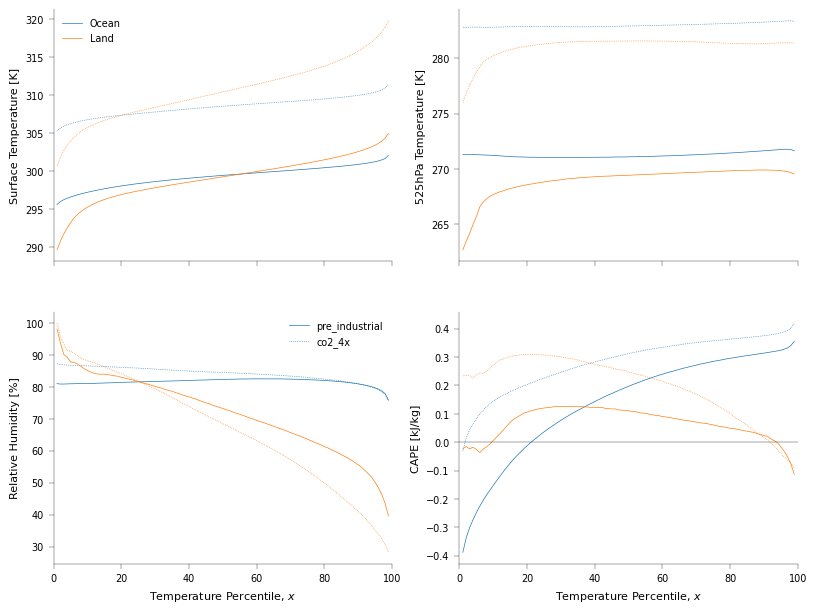

In [55]:
color_surf = [default_colors[0], default_colors[1]]
fig, ax = plt.subplots(2,2, sharex=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*n_surf)
ax = ax.flatten()
for i in range(n_surf):
    for j in range(n_exp):
        for k in range(ds[0].lev.size):
            ax[k].plot(ds[0].quant, plot_sf(ds[j].T.where(ds[j].is_surf).isel(surface=i, lev=k).transpose("lat", "quant")),
                       label=str(ds[0].surface[i].values).capitalize() if j == 0 else None,
                       color=color_surf[i], linestyle=['-', ':'][j])
        # ax[1].plot(ds[0].lat, ds['temp_ft'][i, quant_plot_ind, j], label=str(ds[0].surface[i].values).capitalize() if j == 0 else None,
        #            color=default_colors[1 - i], linestyle=['-', ':'][j])
        ax[2].plot(ds[0].quant, plot_sf(ds[j].rh.where(ds[j].is_surf).isel(surface=i).transpose("lat", "quant")) * 100,
                   color=color_surf[i], linestyle=['-', ':'][j], label=exp_id[j] if i == 0 else None)
        ax[3].plot(ds[0].quant, plot_sf(ds[j].cape_approx.where(ds[j].is_surf).isel(surface=i).transpose("lat", "quant")),
                   color=color_surf[i], linestyle=['-', ':'][j])
ax[2].set_xlabel('Temperature Percentile, $x$')
ax[3].set_xlabel('Temperature Percentile, $x$')
ax[0].set_ylabel('Surface Temperature [K]')
ax[1].set_ylabel('{:.0f}hPa Temperature [K]'.format(pressure_ft/100))
ax[2].set_ylabel('Relative Humidity [%]')
ax[3].set_ylabel('CAPE [kJ/kg]')
ax[3].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(0, 100)
# ax[0].set_xlim(-60, 60)
ax[0].legend()
ax[2].legend()
plt.show()
# plt.plot(lat, ds['mse_lapse'][1, q_plot_ind, 0])
# plt.plot(ds['mse_lapse'][1, q_plot_ind, 1])

### Distribution of locations used in quantile calculation
Here I look at what locations make up the calculations. The first plot clearly shows the lack of land in southern hemisphere, so the amount of data used in these calculations is very much smaller than in the NH.

In [58]:
def get_calc_lon_frac(ds, surf_ind, quant_ind):
    return (ds.use_in_calc.isel(surface=surf_ind, quant=quant_ind).sum(dim='time')/
            ds.use_in_calc.isel(surface=surf_ind, quant=quant_ind).sum(dim='time').sum(dim='lon'))

surf_plot = 'land'
quant_plot = 99
use_in_calc_plot = []
for i in tqdm(range(n_exp)):
    use_in_calc_plot.append(xr.open_dataset(os.path.join(dir_out, f'{exp_id[i]}/{surf_plot}/output.nd2'))
                            ['use_in_calc'].sel(quant=quant_plot, surface=surf_plot).sum(dim='time').load())

  0%|          | 0/2 [00:00<?, ?it/s]

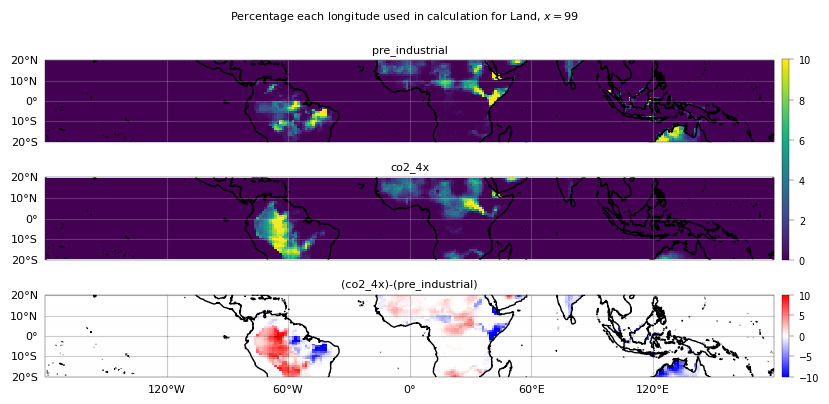

In [59]:
fig, ax = plt.subplots(3, 1, subplot_kw={'projection': ccrs.Mercator()}, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'], ar=20/3)
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[0].lon, ds[0].lat, np.nan_to_num(use_in_calc_plot[i]/use_in_calc_plot[i].sum(dim='lon'), nan=0)*100,
                          transform=ccrs.PlateCarree(), vmin=0, vmax=10)
    ax[i].coastlines()
    ax[i].set_title(exp_id[i])
cbar = fig.colorbar(im, ax=ax[:2].ravel().tolist(), orientation='vertical', aspect=27, pad=0.01, fraction=0.01)
im = ax[2].pcolormesh(ds[0].lon, ds[0].lat, np.nan_to_num(use_in_calc_plot[1]/use_in_calc_plot[1].sum(dim='lon') -
                                                          use_in_calc_plot[0]/use_in_calc_plot[0].sum(dim='lon'), nan=0)*100,
                      transform=ccrs.PlateCarree(),
                      vmin=-10, vmax=10, cmap='bwr')
cbar = fig.colorbar(im, ax=ax[2:].ravel().tolist(), orientation='vertical', aspect=11, pad=0.01, fraction=0.01)
ax[2].coastlines()
ax[0].set_extent([-180, 180, -20.01, 20.01], crs=ccrs.PlateCarree())
ax[2].set_title(f'({exp_id[1]})-({exp_id[0]})')
# Add gridlines with labels
for i in range(len(ax)):
    gl = ax[i].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.2, color='w' if i<=1 else 'k')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True if i==2 else None
    gl.ylocator = mticker.FixedLocator(np.arange(-20, 21, 10))
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
fig.suptitle(f"Percentage each longitude used in calculation for {surf_plot.capitalize()}, "
             f"$x={quant_plot}$", fontsize=8)
# plt.subplots_adjust(wspace=0.01)
plt.show()